In [3]:
#liberar memoria de la GPU  
#from numba import cuda
#cuda.select_device(0)
##cuda.select_device(1)
#cuda.close()
#from tensorflow.keras import backend as K
#K.clear_session()
#liberar memoria de la RAM
#import gc
#gc.collect()


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-11-30 11:49:21.273311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 11:49:24.462274: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-30 11:49:24.462397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-30 11:49:24.462405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  2


2023-11-30 11:49:26.779588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:26.783071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.168549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.171383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.174082: I tensorflow/compiler/xla/stream_executo

## Librerias y cargar dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from google.colab import files
import zipfile

2023-12-05 13:19:22.203546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 13:19:22.881380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-05 13:19:22.881429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-05 13:19:22.881434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [6]:
#uploaded = files.upload()

Descomprimir dataset

In [7]:
#with zipfile.ZipFile("DroughtDatasetMask.zip", 'r') as data:
#    data.extractall("DroughtDatasetMask/dataset")

## Funciones

In [3]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img


#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux


def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)


def add_last(data, new_vals):
    print(f"data: {data.shape} y new_val: {new_vals.shape}")
    x_test_new = data[:,1:]
    print(f"x_test_new: {x_test_new.shape}")

    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

def add_lastNew(data, new_val):
    print(f"data: {data.shape} y new_val: {new_val.shape}")
    x_test_new = data[:,1:,...]  # Omite el primer paso de tiempo
    print(f"x_test_new: {x_test_new.shape}")

    # Asumiendo que new_val es una única predicción que se debe añadir a cada paso de tiempo en x_test_new
    new_val = new_val.squeeze(axis=0)  # Elimina la dimensión del batch, si es necesario

    print(new_val.shape)
    # Añadir new_val a cada elemento en x_test_new
    x_test_new = np.concatenate((x_test_new, np.expand_dims(new_val, axis=1)), axis=1)

    print("CX", x_test_new.shape)
    return x_test_new


    #Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

## Codigo

Variables iniciales para correr el codigo

In [3]:
rows = 61
cols = 180
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255] 
horizon = 4
parte = "Part0_1"

De la carpeta con las imagenes pasarlo a un arreglo npy

(1240, 61, 180)


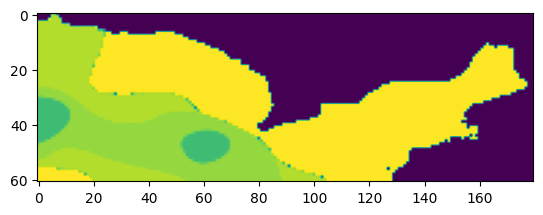

In [9]:
#cargar npy de parte y mostrar primera imagen 
data = np.load(f"DroughtDatasetMask/NPY61_180Part0_1/DroughtDatasetMask_Part0_1.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()

# superior derecha

img recortada (61, 190, 3)


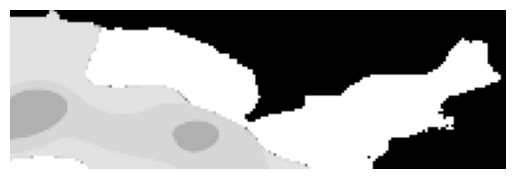

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Asumamos que tienes la imagen cargada en el notebook como un array de numpy
# Si necesitas cargarla desde un archivo, puedes usar cv2.imread('ruta_al_archivo')
imagen_original = cv2.imread('DroughtDatasetMask/dataset/DroughtDatasetMask/2000-01-04.png')

# Dimensiones deseadas para el recorte
altura_deseada = 61
ancho_deseado = 190

# Calcular el punto de inicio del recorte
inicio_x = imagen_original.shape[1] - ancho_deseado
inicio_y = 0  # Desde la parte superior

# Realizar el recorte
imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

print("img recortada", imagen_recortada.shape)
# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')  # No mostrar los ejes
plt.show()



recorte de la img

In [33]:
import cv2
import os

# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/DroughtDatasetMask'

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
images = []  # List to store the images
# Loop through the image files
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    imagen_original = cv2.imread(image_path)

    # Dimensiones deseadas para el recorte
    altura_deseada = 61
    ancho_deseado = 190

    # Calcular el punto de inicio del recorte
    inicio_x = imagen_original.shape[1] - ancho_deseado
    inicio_y = 0  # Desde la parte superior

    # Realizar el recorte
    imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

    # añadir la imagen a una carpeta
    cv2.imwrite(f'DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/dataset/{file}', imagen_recortada)
    

creacion del npy

In [9]:
import cv2
import os
import numpy as np

# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/dataset'

# Get a sorted list of all the image file names in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Create an empty list to hold the images
images = []

# Loop through the sorted image files and add each image to the list
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    image = cv2.imread(image_path)
    #print(file)
    #pasar a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    # Add the image to the list
    images.append(image)

# Convert the list of images to a numpy array
images_array = np.array(images)

# Print the shape of the numpy array
print(images_array.shape)

# Save the numpy array to a file
np.save('DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/DroughtDatasetMaskBordesNuevos0_1v2.npy', images_array)


(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)
(61, 190)


(1240, 61, 190, 3)


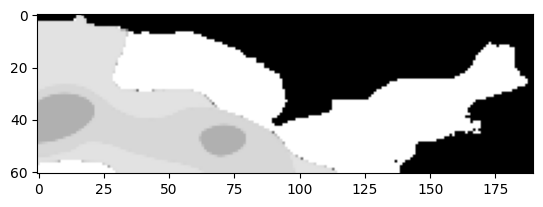

In [50]:
#cargar npy de parte y mostrar primera imagen
data = np.load(f"DroughtDatasetMask/dataset/BordesNuevos/61_180Part0_1/DroughtDatasetMaskBordesNuevosv20_1.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()


# inferior izquierda

(1240, 61, 180)


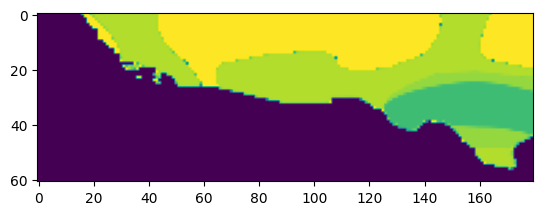

In [23]:
#cargar npy de parte y mostrar primera imagen 
data = np.load(f"DroughtDatasetMask/NPY61_180Part1_0/DroughtDatasetMask_Part1_0.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()

inicio x 0
inicio y 51
img recortada (71, 180, 3)


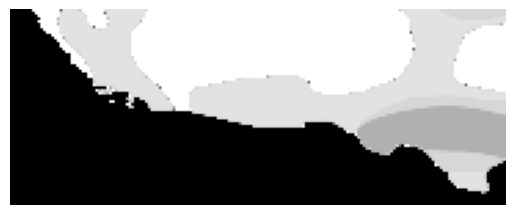

In [22]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Asumamos que tienes la imagen cargada en el notebook como un array de numpy
# Si necesitas cargarla desde un archivo, puedes usar cv2.imread('ruta_al_archivo')
imagen_original = cv2.imread('DroughtDatasetMask/dataset/DroughtDatasetMask/2000-01-04.png')

# Dimensiones deseadas para el recorte
altura_deseada = 71
ancho_deseado = 180

# Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
inicio_x = 0
inicio_y = imagen_original.shape[0] - altura_deseada

print("inicio x", inicio_x)
print("inicio y", inicio_y)
# Realizar el recorte
imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

print("img recortada", imagen_recortada.shape)
# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')  # No mostrar los ejes
plt.show()

recorte de la img

In [52]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/DroughtDatasetMask'

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
images = []  # List to store the images
# Loop through the image files
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    imagen_original = cv2.imread(image_path)
    # Dimensiones deseadas para el recorte
    altura_deseada = 71
    ancho_deseado = 180

    # Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
    inicio_x = 0
    inicio_y = imagen_original.shape[0] - altura_deseada

    # Realizar el recorte
    imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]


    # añadir la imagen a una carpeta
    cv2.imwrite(f'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/dataset/{file}', imagen_recortada)

creacion del npy

In [8]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/dataset'

# Get a sorted list of all the image file names in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Create an empty list to hold the images
images = []

# Loop through the sorted image files and add each image to the list
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    image = cv2.imread(image_path)
    #print(file)
    #pasar a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    # Add the image to the list
    images.append(image)

# Convert the list of images to a numpy array
images_array = np.array(images)

# Print the shape of the numpy array
print(images_array.shape)

# Save the numpy array to a file
np.save('DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/DroughtDatasetMaskBordesNuevos1_0v2.npy', images_array)

(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)
(71, 180)


(1240, 71, 180, 3)


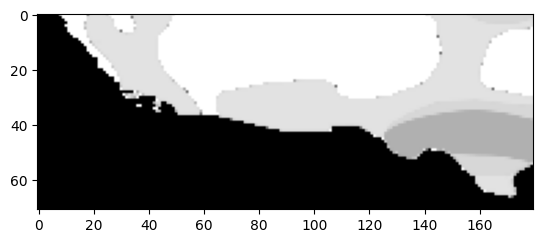

In [57]:
#cargar npy de parte y mostrar primera imagen 
data1_0 = np.load(f"DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_0/DroughtDatasetMaskBordesNuevos1_0.npy")
print(data1_0.shape)
plt.imshow(data1_0[0])
plt.show()

# Inferior derecha

(1240, 61, 180)


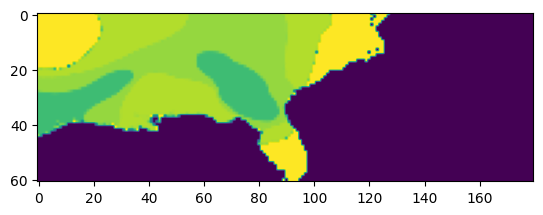

In [5]:
#cargar npy de parte y mostrar primera imagen 
data = np.load(f"DroughtDatasetMask/NPY61_180Part1_1/DroughtDatasetMask_Part1_1.npy")
print(data.shape)
plt.imshow(data[0])
plt.show()

img recortada (71, 190, 3)


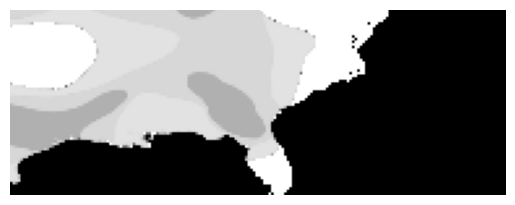

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Asumamos que tienes la imagen cargada en el notebook como un array de numpy
# Si necesitas cargarla desde un archivo, puedes usar cv2.imread('ruta_al_archivo')
imagen_original = cv2.imread('DroughtDatasetMask/dataset/DroughtDatasetMask/2000-01-04.png')

# Dimensiones deseadas para el recorte
altura_deseada = 71
ancho_deseado = 190

# Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
inicio_x = imagen_original.shape[1] - ancho_deseado
inicio_y = imagen_original.shape[0] - altura_deseada

# Realizar el recorte
imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]

print("img recortada", imagen_recortada.shape)
# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(imagen_recortada, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente
plt.axis('off')  # No mostrar los ejes
plt.show()

recorte de la img

In [53]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/DroughtDatasetMask'

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
images = []  # List to store the images
# Loop through the image files
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    imagen_original = cv2.imread(image_path)

    # Dimensiones deseadas para el recorte
    altura_deseada = 71
    ancho_deseado = 190

    # Calcular el punto de inicio del recorte (desde la parte inferior izquierda)
    inicio_x = imagen_original.shape[1] - ancho_deseado
    inicio_y = imagen_original.shape[0] - altura_deseada

    # Realizar el recorte
    imagen_recortada = imagen_original[inicio_y:inicio_y + altura_deseada, inicio_x:inicio_x + ancho_deseado]


    # añadir la imagen a una carpeta
    cv2.imwrite(f'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/dataset/{file}', imagen_recortada)

creacion de numpy inferior derecha

In [7]:
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/dataset'

# Get a sorted list of all the image file names in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Create an empty list to hold the images
images = []

# Loop through the sorted image files and add each image to the list
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    image = cv2.imread(image_path)
    #print(file)
    #pasar a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    # Add the image to the list
    images.append(image)

# Convert the list of images to a numpy array
images_array = np.array(images)

# Print the shape of the numpy array
print(images_array.shape)

# Save the numpy array to a file
np.save('DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/DroughtDatasetMaskBordesNuevos1_1v2.npy', images_array)

(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)
(71, 190)


visualizar data 0

(1240, 71, 190, 3)


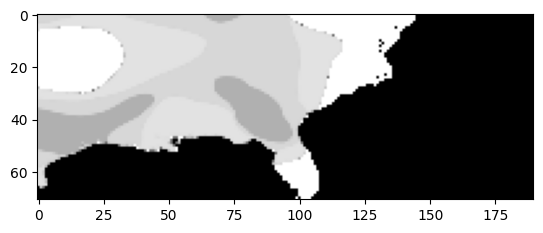

In [59]:
#cargar npy de parte y mostrar primera imagen 
data1_1 = np.load(f"DroughtDatasetMask/dataset/BordesNuevos/61_180Part1_1/DroughtDatasetMaskBordesNuevos1_1.npy")
print(data1_1.shape)
plt.imshow(data1_1[0])
plt.show()

# fin

In [60]:
x = np.load(f"DroughtDatasetMask/NPY61_180Part0_1/DroughtDatasetMask_Part0_1.npy")

Displaying frames for example 307


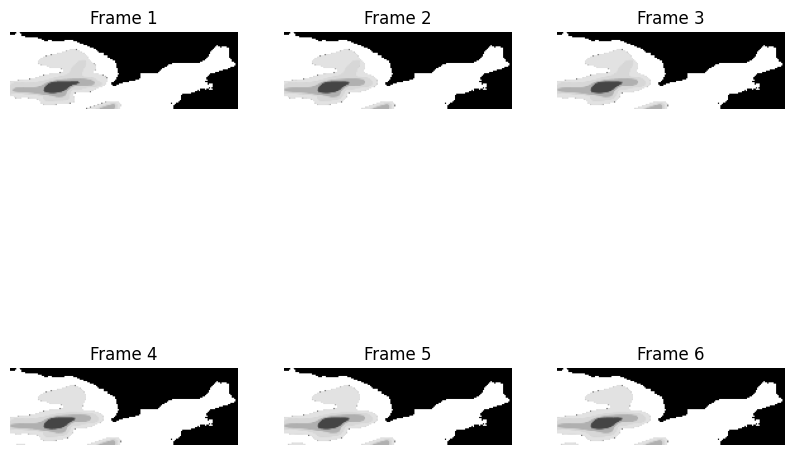

In [63]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))

data_choise = np.random.choice(range(len(x)), size= 1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

Displaying frames for example 307


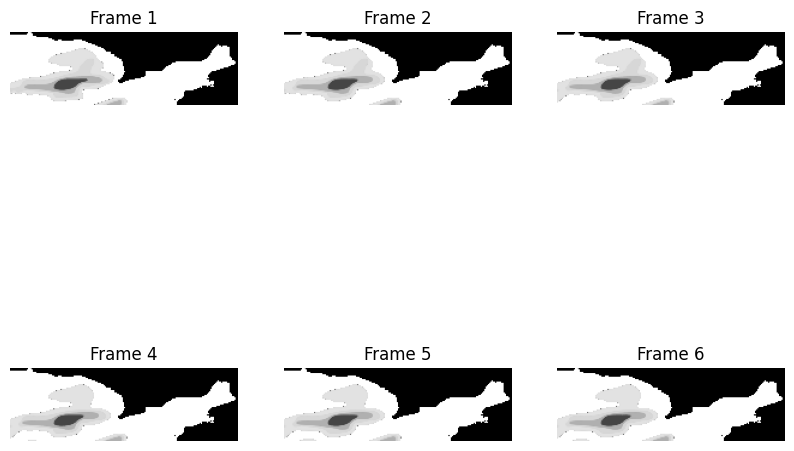

In [64]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(data[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

# Nuevo codigo de recorte de los bordes

Se realiza el recorte de las imagenes en 2x2, 3x3, 4x4

In [25]:
import cv2
import os

def crop_and_save(image, x, y, width, height, destination_folder, filename):
    cropped_image = image[y:y+height, x:x+width]
    cv2.imwrite(os.path.join(destination_folder, filename), cropped_image)

# Ruta al directorio con imágenes originales
folder_path = 'DroughtDatasetMask/ActualizacionDataSetMani/imagenesMak1'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

# Ruta al directorio donde se guardarán las imágenes recortadas
folder_save = 'DroughtDatasetMask/DataSetBordesAutomatico/Prueba1'

# Define the cropping dimensions for each size
sizes = {
    '1X1': [(0, 0, 360, 122)]
    #'2X2': [(0, 0, 180, 61), (170, 0, 190, 61), (0, 51, 180, 71), (170, 51, 190, 71)],
    #'3X3': [(0, 0, 120, 41), (110, 0, 130, 41), (230, 0, 130, 41), (0, 31, 120, 51), (110, 31, 130, 51), (230, 31, 130, 51), (0, 71, 120, 51), (110, 71, 130, 51), (230, 71, 130, 51)],
    #'4X4': [(0, 0, 90, 31), (80, 0, 100, 31), (170, 0, 100, 31), (260, 0, 100, 31), (0, 21, 90, 41), (80, 21, 100, 41), (170, 21, 100, 41), (260, 21, 100, 41), (0, 51, 90, 41), (80, 51, 100, 41), (170, 51, 100, 41), (260, 51, 100, 41), (0, 81, 90, 41), (80, 81, 100, 41), (170, 81, 100, 41), (260, 81, 100, 41)]
}

# Primero recorrer las dimensiones de recorte
for size, dimensions in sizes.items():
    size_folder = os.path.join(folder_save, size)
    os.makedirs(size_folder, exist_ok=True)
    print (f"size_folder, {size_folder}")
    # Dentro de cada dimensión, recorrer las imágenes
    for i, (x, y, width, height) in enumerate(dimensions):
        for file in image_files:
            image_path = os.path.join(folder_path, file)
            image = cv2.imread(image_path)

            filename = os.path.splitext(file)[0]
            cropped_filename = f"{filename}_{size}_{i}.jpg"

            
            crop_folder = os.path.join(size_folder, f"crop_{i}")

            #print (f"crop_folder, {crop_folder}")
            
            if not os.path.exists(crop_folder):
                os.makedirs(crop_folder)

            crop_and_save(image, x, y, width, height, crop_folder, cropped_filename)


size_folder, DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/1X1


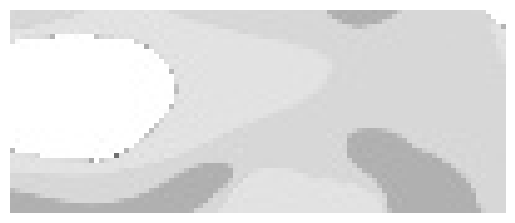

Image shape: (41, 100, 3)


In [17]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = 'DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/4X4/crop_10/2000-01-04_4X4_10.jpg' 
image = cv2.imread(image_path)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Print the shape of the image
print("Image shape:", image.shape)


Creacion de numpy de los diferentes tamaños

In [26]:
import numpy as np
# Set the path to the folder containing the images
folder_path = 'DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/1X1/crop_0'

# Get a sorted list of all the image file names in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')])

# Create an empty list to hold the images
images = []

# Loop through the sorted image files and add each image to the list
for file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(folder_path, file)
    image = cv2.imread(image_path)
    #print(file)
    #pasar a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(image.shape)
    # Add the image to the list
    images.append(image)

# Convert the list of images to a numpy array
images_array = np.array(images)

# Print the shape of the numpy array
print(images_array.shape)

# Save the numpy array to a file
np.save('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/1x1/DroughtDatasetMask1x1.npy', images_array)

(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)
(122, 360)

## Vista de los recortes 3x3

image0, (41, 120, 3)
image1, (41, 130, 3)
image2, (41, 130, 3)
image3, (51, 120, 3)
image4, (51, 130, 3)
image5, (51, 130, 3)
image6, (51, 120, 3)
image7, (51, 130, 3)
image8, (51, 130, 3)


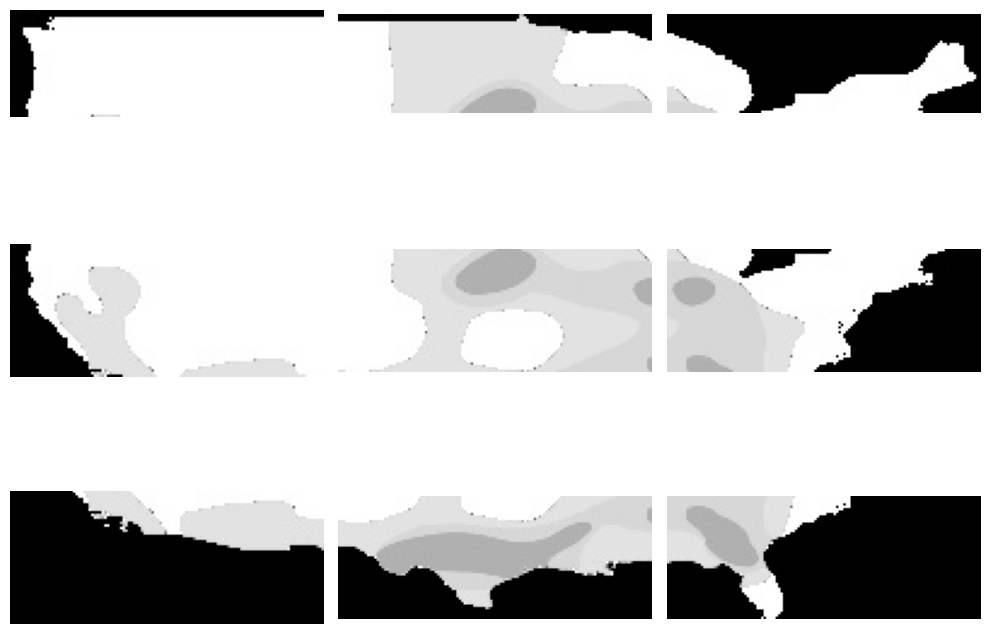

In [41]:
import matplotlib.pyplot as plt
import cv2

# Load the images
image0 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_0/2000-01-04_3X3_0.jpg')
image1 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_1/2000-01-04_3X3_1.jpg')
image2 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_2/2000-01-04_3X3_2.jpg')

image3 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_3/2000-01-04_3X3_3.jpg')
image4 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_4/2000-01-04_3X3_4.jpg')
image5 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_5/2000-01-04_3X3_5.jpg')

image6 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_6/2000-01-04_3X3_6.jpg')
image7 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_7/2000-01-04_3X3_7.jpg')
image8 = cv2.imread('DroughtDatasetMask/DataSetBordesAutomatico/Prueba1/3X3/crop_8/2000-01-04_3X3_8.jpg')

print (f"image0, {image0.shape}")
print (f"image1, {image1.shape}")
print (f"image2, {image2.shape}")
print (f"image3, {image3.shape}")
print (f"image4, {image4.shape}")
print (f"image5, {image5.shape}")
print (f"image6, {image6.shape}")
print (f"image7, {image7.shape}")
print (f"image8, {image8.shape}")

# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Display the images
axes[0, 0].imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB))
axes[0, 0].axis('off')
axes[0, 1].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axes[0, 1].axis('off')
axes[0, 2].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[0, 2].axis('off')
plt.tight_layout()
axes[1, 0].imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
axes[1, 0].axis('off')
axes[1, 1].imshow(cv2.cvtColor(image4, cv2.COLOR_BGR2RGB))
axes[1, 1].axis('off')
axes[1, 2].imshow(cv2.cvtColor(image5, cv2.COLOR_BGR2RGB))
axes[1, 2].axis('off')
plt.tight_layout()
axes[2, 0].imshow(cv2.cvtColor(image6, cv2.COLOR_BGR2RGB))
axes[2, 0].axis('off')
axes[2, 1].imshow(cv2.cvtColor(image7, cv2.COLOR_BGR2RGB))
axes[2, 1].axis('off')
axes[2, 2].imshow(cv2.cvtColor(image8, cv2.COLOR_BGR2RGB))
axes[2, 2].axis('off')
plt.tight_layout()
# Show the figure
plt.show()


## vista de los recortes 4x4

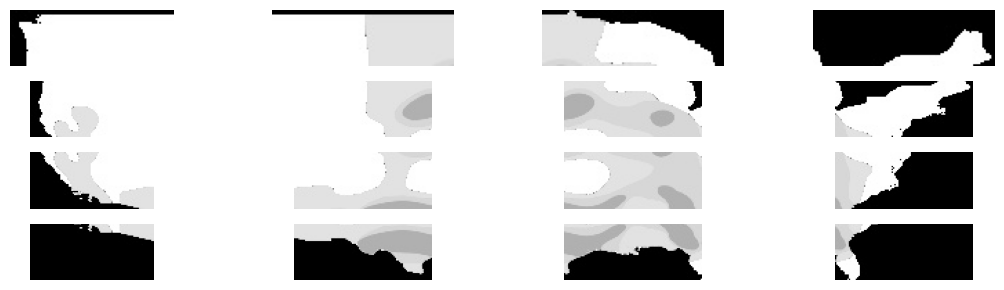

In [81]:
# Load the images from the npy file
image0 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop0.npy')
image1 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop1.npy')
image2 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop2.npy')
image3 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop3.npy')
image4 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop4.npy')
image5 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop5.npy')
image6 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop6.npy')
image7 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop7.npy')
image8 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop8.npy')
image9 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop9.npy')
image10 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop10.npy')
image11 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop11.npy')
image12 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop12.npy')
image13 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop13.npy')
image14 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop14.npy')
image15 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop15.npy')

# Create a figure with subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 3))

# Display the images
axes[0][0].imshow(cv2.cvtColor(image0[0], cv2.COLOR_BGR2RGB))
axes[0][0].axis('off')
axes[0][1].imshow(cv2.cvtColor(image1[0], cv2.COLOR_BGR2RGB))
axes[0][1].axis('off')
axes[0][2].imshow(cv2.cvtColor(image2[0], cv2.COLOR_BGR2RGB))
axes[0][2].axis('off')
axes[0][3].imshow(cv2.cvtColor(image3[0], cv2.COLOR_BGR2RGB))
axes[0][3].axis('off')
plt.tight_layout()
axes[1][0].imshow(cv2.cvtColor(image4[0], cv2.COLOR_BGR2RGB))
axes[1][0].axis('off')
axes[1][1].imshow(cv2.cvtColor(image5[0], cv2.COLOR_BGR2RGB))
axes[1][1].axis('off')
axes[1][2].imshow(cv2.cvtColor(image6[0], cv2.COLOR_BGR2RGB))
axes[1][2].axis('off')
axes[1][3].imshow(cv2.cvtColor(image7[0], cv2.COLOR_BGR2RGB))
axes[1][3].axis('off')
plt.tight_layout()
axes[2][0].imshow(cv2.cvtColor(image8[0], cv2.COLOR_BGR2RGB))
axes[2][0].axis('off')
axes[2][1].imshow(cv2.cvtColor(image9[0], cv2.COLOR_BGR2RGB))
axes[2][1].axis('off')
axes[2][2].imshow(cv2.cvtColor(image10[0], cv2.COLOR_BGR2RGB))
axes[2][2].axis('off')
axes[2][3].imshow(cv2.cvtColor(image11[0], cv2.COLOR_BGR2RGB))
axes[2][3].axis('off')
plt.tight_layout()
axes[3][0].imshow(cv2.cvtColor(image12[0], cv2.COLOR_BGR2RGB))
axes[3][0].axis('off')
axes[3][1].imshow(cv2.cvtColor(image13[0], cv2.COLOR_BGR2RGB))
axes[3][1].axis('off')
axes[3][2].imshow(cv2.cvtColor(image14[0], cv2.COLOR_BGR2RGB))
axes[3][2].axis('off')
axes[3][3].imshow(cv2.cvtColor(image15[0], cv2.COLOR_BGR2RGB))
axes[3][3].axis('off')

plt.tight_layout()
# Show the figure
plt.show()



Carga del  numpy y muestra de la imagen

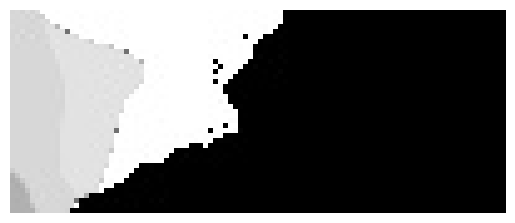

In [84]:
image0 = np.load('DroughtDatasetMask/DataSetBordesAutomatico/Numpys/4X4/DroughtDatasetMask_4X4_crop11.npy')

# Display the image
plt.imshow(image0[0], cmap='gray')
plt.axis('off')
plt.show()
